In [1]:
import os
import pandas as pd
from tkinter.filedialog import askopenfilename
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf, erfinv # Modified code to include ionization factor (N^2/3)
from scipy.optimize import curve_fit
from math import exp,sqrt, log, sinh, cosh, floor
from pathlib import Path
import Deflection_Lib as funcs #File containing some helper functions
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets
import pathlib
from datetime import date

In [2]:
class simulation_parameters:
    undeflected_left_boundary = None #domain of zero-field profile
    undeflected_right_boundary = None
    undeflected_data_x_vals = None
    undeflected_data_y_vals = None
    undeflected_data_max = None

    deflected_data_x_vals = None
    deflected_data_y_vals = None
    deflected_sim_right_bound = None
    deflected_sim_left_bound = None

    simulated_deflection_data_x_vals = None

    rat = 0.9 #0.649336  #ratio of standard deviation to average droplet size
    vx = 0.2 #velocity in the x-direction for a particular droplet; used by Droplet() & Deflection()
    vz = 0.0 #velocity in the z-direction for a particular droplet; used by Deflection()

    moleculeName = "Cl2Fe" ## Name of Molecule Used in Simulation
    mDop = 126.75*1.66E-27 ## Multiply to change from amu to kg
    pDop = 5.4             ## Magnetic moment of dopant (if known)
    TDop = 638             ## Temperature of the dopant in a given experiment

    v0 = 256          # From MCS data
    number_of_iterations = int(1e4)   #Max number of trials per position in zero field data # JN quintupled
    startAveN = 10000       # Reasonable first Guess
    maxAveN = 14000         # Upper limit for loop

    startMoment = 0         # first guess for moment
    maxMoment = 8           # upper limit for moment
    increment = 500   # Change in droplet size per loop
    loopLimit = int((maxAveN - startAveN)/increment+1)

    vibration_Boiloff = 1654

out = widgets.Output(layout={'border': '1px solid black'})
# size simulation
def size_generator(sim_parameters):
    aveN = sim_parameters.startAveN
    plt.plot(sim_parameters.deflected_data_x_vals,sim_parameters.deflected_data_y_vals)
    time_start = time.perf_counter()

    loading_bar=widgets.IntProgress(
    value=0,
    min=0,
    max=sim_parameters.loopLimit,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'maroon'},
    orientation='horizontal'
    )

    for j in range(sim_parameters.loopLimit):  

        totalDrops = 0
        totalSizes = 0
        totalSurvivingDrops = 0
        simulated_deflection_data_y_vals = np.zeros(len(sim_parameters.deflected_data_x_vals),dtype=float) # Instantiate array for sim output's xvals
        profHe = np.zeros(len(sim_parameters.deflected_data_x_vals)) #Output Droplet Profile
        sizes = np.zeros(len(sim_parameters.deflected_data_x_vals)) #Average size of droplets as a function of position
        # This goes through each of the starting positions of imported file, need to switch with
        # the x values of the fitted profile. Right now, imported file is fitted data, but need to generalize


        mu = 0.5*log( (aveN*aveN) / (1.0 + sim_parameters.rat*sim_parameters.rat) )
        sig = sqrt( log(1.0 + sim_parameters.rat*sim_parameters.rat ) )  #sigma in log-normal distribution
        maxN = np.exp(sqrt(2.0)* sig * erfinv(2.0 * 0.9999 - 1.0) + mu) # Actually 99.9 th percentile droplet, which we'll call maximum
        ionNorm = maxN**(2.0/3.0)

        for i in range(len(sim_parameters.undeflected_data_x_vals)):


            x0 = sim_parameters.undeflected_data_x_vals[i] #Position at detector without deflection
            NIcrit = 0
            while NIcrit < int(np.around(sim_parameters.number_of_iterations*sim_parameters.undeflected_data_y_vals[i] /sim_parameters.undeflected_data_max)):
                    # While loop runs until there are enough droplets that survive the gaunlet
                    # to match the intensity of the input profile assuming that the maximum of the profile
                    # has number_of_iterations droplets that survive. So the wings have Y(x)*number_of_iterations/Max survived droplets 
                    N = int(np.random.lognormal( mu , sig )) # Generate droplet of size N
                    sim_parameters.vz = np.random.normal(sim_parameters.v0, 0.03*sim_parameters.v0)
                    totalDrops += 1
                    if np.random.random() < N**(2.0/3.0)/ionNorm: # Dopant pick up as a function of cross section
                        N -= sim_parameters.vibration_Boiloff
                        N = funcs.Boiloff(N,sim_parameters.mDop,sim_parameters.TDop,sim_parameters.vz)
                        if np.random.random() < N**(2.0/3.0)/ionNorm: # Ionizes Droplet
                            if np.random.random() < exp(-0.06*(N**(1.0/3.0))): #CTP step
                                if N>0:
                                    NIcrit += 1    #Keeps track of the total number of iterations
                                    totalSurvivingDrops += 1
                                    x = x0 - funcs.MagneticDeflection(N,sim_parameters.pDop,sim_parameters.mDop,sim_parameters.v0)	#net deflection of a doped helium droplet
                                    
        
                                    
                                    if (x< sim_parameters.deflected_sim_right_bound) & (x>sim_parameters.deflected_sim_left_bound): #If position in range

                                        nearest_x = funcs.find_nearest(sim_parameters.deflected_data_x_vals, x )
                                        k = np.where(sim_parameters.deflected_data_x_vals == nearest_x)[0][0]
                                        simulated_deflection_data_y_vals[k] += 1 # and molecule is ionized, then add to profile at k index corresponding to x position of deflected droplet
                                        profHe[k] += 1 #relative yield of dopants
                                        sizes[k] += N
                                        totalSizes += N
        sizes = sizes / profHe.astype(float)

        normed_simulated_deflection_data_y_vals = (sim_parameters.undeflected_data_max / sim_parameters.number_of_iterations) * simulated_deflection_data_y_vals
        output_combined = np.transpose([sim_parameters.deflected_data_x_vals,normed_simulated_deflection_data_y_vals])
        sizes_combined = np.transpose([sim_parameters.deflected_data_x_vals,sizes])

        np.savetxt("z_"+ str(aveN) +"_deflection.tsv", output_combined, delimiter="\t")
        np.savetxt("z_"+ str(aveN) +"_sizes.tsv", sizes_combined, delimiter="\t")

       
        with out:
            out.clear_output()
            loading_bar=widgets.IntProgress(
            value=j,
            min=0,
            max=sim_parameters.loopLimit,
            description='Loading:',
            bar_style='', # 'success', 'info', 'warning', 'danger' or ''
            style={'bar_color': 'maroon'},
            orientation='horizontal'
            )
            display(loading_bar)
            print("Starting Size: "+ str(aveN))
            print("Average Surviving Droplet Size: "+ str(int(totalSizes/totalSurvivingDrops)))
            print("Total Droplets Generated: "+ str(totalDrops))
            print("Survival Rate: "+ str(round(totalSurvivingDrops/totalDrops*100, 3)) +" %")

            plt.plot(sim_parameters.deflected_data_x_vals,normed_simulated_deflection_data_y_vals)
            print("Time Elapsed: ", round((time.perf_counter()-time_start)/60,2), " Minutes")

        aveN += sim_parameters.increment
        
        
    print("SIMULATION CONCLUDED")


# moment simulator
def monomer_moment_solver(sim_parameters):
    moment = sim_parameters.startMoment
    aveN = sim_parameters.startAveN
    plt.plot(sim_parameters.deflected_data_x_vals,sim_parameters.deflected_data_y_vals)
    time_start = time.perf_counter()
    loading_bar=widgets.IntProgress(
    value=0,
    min=0,
    max=sim_parameters.loopLimit,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'maroon'},
    orientation='horizontal'
    )

    mu = 0.5*log( (aveN*aveN) / (1.0 + sim_parameters.rat*sim_parameters.rat) )
    sig = sqrt( log(1.0 + sim_parameters.rat*sim_parameters.rat ) )  #sigma in log-normal distribution
    maxN = np.exp(sqrt(2.0)* sig * erfinv(2.0 * 0.9999 - 1.0) + mu) # Actually 99.9 th percentile droplet, which we'll call maximum
    ionNorm = maxN**(2.0/3.0)    

    for j in range(sim_parameters.loopLimit):  

        totalDrops = 0
        totalSizes = 0
        totalSurvivingDrops = 0
        simulated_deflection_data_y_vals = np.zeros(len(sim_parameters.deflected_data_x_vals),dtype=float) # Instantiate array for sim output's xvals
        profHe = np.zeros(len(sim_parameters.deflected_data_x_vals)) #Output Droplet Profile
        sizes = np.zeros(len(sim_parameters.deflected_data_x_vals)) #Average size of droplets as a function of position
        # This goes through each of the starting positions of imported file, need to switch with
        # the x values of the fitted profile. Right now, imported file is fitted data, but need to generalize


        

        for i in range(len(sim_parameters.undeflected_data_x_vals)):


            x0 = sim_parameters.undeflected_data_x_vals[i] #Position at detector without deflection
            NIcrit = 0
            while NIcrit < int(np.around(sim_parameters.number_of_iterations*sim_parameters.undeflected_data_y_vals[i] /sim_parameters.undeflected_data_max)):
                    # While loop runs until there are enough droplets that survive the gaunlet
                    # to match the intensity of the input profile assuming that the maximum of the profile
                    # has number_of_iterations droplets that survive. So the wings have Y(x)*number_of_iterations/Max survived droplets 
                    N = int(np.random.lognormal( mu , sig )) # Generate droplet of size N
                    sim_parameters.vz = np.random.normal(sim_parameters.v0, 0.03*sim_parameters.v0)
                    totalDrops += 1
                    if np.random.random() < N**(2.0/3.0)/ionNorm: # Dopant pick up as a function of cross section
                        N -= sim_parameters.vibration_Boiloff
                        N = funcs.Boiloff(N,sim_parameters.mDop,sim_parameters.TDop,sim_parameters.vz)
                        if np.random.random() < N**(2.0/3.0)/ionNorm: # Ionizes Droplet
                            if np.random.random() < exp(-0.06*(N**(1.0/3.0))): #CTP step
                                if N>0:
                                    NIcrit += 1    #Keeps track of the total number of iterations
                                    totalSurvivingDrops += 1
                                    x = x0 - funcs.MagneticDeflection(N,moment,sim_parameters.mDop,sim_parameters.v0)	#net deflection of a doped helium droplet
                                    
        
                                    
                                    if (x< sim_parameters.deflected_sim_right_bound) & (x>sim_parameters.deflected_sim_left_bound): #If position in range

                                        nearest_x = funcs.find_nearest(sim_parameters.deflected_data_x_vals, x )
                                        k = np.where(sim_parameters.deflected_data_x_vals == nearest_x)[0][0]
                                        simulated_deflection_data_y_vals[k] += 1 # and molecule is ionized, then add to profile at k index corresponding to x position of deflected droplet
                                        profHe[k] += 1 #relative yield of dopants
                                        sizes[k] += N
                                        totalSizes += N
        sizes = sizes / profHe.astype(float)

        normed_simulated_deflection_data_y_vals = (sim_parameters.undeflected_data_max / sim_parameters.number_of_iterations) * simulated_deflection_data_y_vals
        output_combined = np.transpose([sim_parameters.deflected_data_x_vals,normed_simulated_deflection_data_y_vals])
        sizes_combined = np.transpose([sim_parameters.deflected_data_x_vals,sizes])

        np.savetxt("y_"+ str(aveN) +"_" +str(round(moment,4)) +"_deflection.tsv", output_combined, delimiter="\t")
        np.savetxt("y_"+ str(aveN) +"_" +str(round(moment,4)) +"_sizes.tsv", sizes_combined, delimiter="\t")

       
        with out:
            out.clear_output()
            loading_bar=widgets.IntProgress(
            value=j,
            min=0,
            max=sim_parameters.loopLimit,
            description='Loading:',
            bar_style='', # 'success', 'info', 'warning', 'danger' or ''
            style={'bar_color': 'maroon'},
            orientation='horizontal'
            )
            display(loading_bar)
            print("Starting Size: "+ str(aveN) + " at moment size: " + str(round(moment,4)))
            print("Average Surviving Droplet Size: "+ str(int(totalSizes/totalSurvivingDrops)))
            print("Total Droplets Generated: "+ str(totalDrops))
            print("Survival Rate: "+ str(round(totalSurvivingDrops/totalDrops*100, 3)) +" %")

            plt.plot(sim_parameters.deflected_data_x_vals,normed_simulated_deflection_data_y_vals)
            print("Time Elapsed: ", round((time.perf_counter()-time_start)/60,2), " Minutes")

        moment += sim_parameters.increment
        
        
    print("SIMULATION CONCLUDED")

In [3]:
#File upload section
undeflected_name = askopenfilename(title="SELECT UNDEFLECTED DATA", initialfile="1_Fitted_Undeflected_Data")
undeflected_data = np.loadtxt(undeflected_name)

simulation_parameters.undeflected_left_boundary = undeflected_data[0,0] #domain of zero-field profile
simulation_parameters.undeflected_right_boundary = undeflected_data[-1,0]
simulation_parameters.undeflected_data_x_vals = undeflected_data[:,0]
simulation_parameters.undeflected_data_y_vals = undeflected_data[:,1]
simulation_parameters.undeflected_data_max = max(simulation_parameters.undeflected_data_y_vals)

deflected_name = askopenfilename(title="SELECT DEFLECTED DATA", initialfile= "2_Fitted_Deflected_Data")
deflected_data =  np.loadtxt(deflected_name)

simulation_parameters.deflected_data_x_vals = deflected_data[:,0]
simulation_parameters.deflected_data_y_vals = deflected_data[:,1]
simulation_parameters.deflected_sim_right_bound = simulation_parameters.deflected_data_x_vals[-1]
simulation_parameters.deflected_sim_left_bound = simulation_parameters.deflected_data_x_vals[0]

simulation_parameters.simulated_deflection_data_x_vals = simulation_parameters.deflected_data_x_vals  # Instantiate array for sim output's xvals

/var/folders/td/r0_5445n3v9ckj5qkw51xjlw0000gn/T/ipykernel_65742/3783312704.py:207: RuntimeWarning: invalid value encountered in divide
  sizes = sizes / profHe.astype(float)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ryanc/Desktop/Kresin_Lab_Simulation_Master_Template/Monomer_2024-08-21/y_7000_6.0_deflection.tsv'

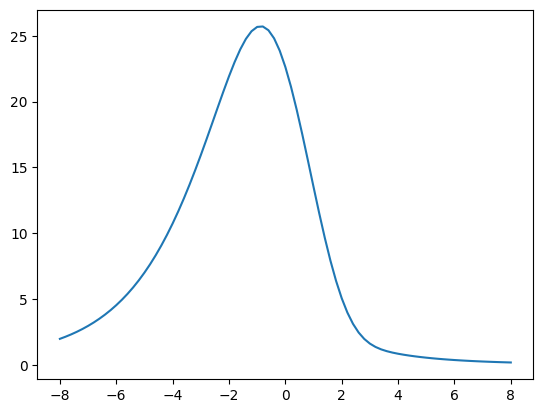

In [4]:

#Variable definitions
rat_ = widgets.Text(value='0.9',placeholder='0.9',description='rat',disabled=False)
vx_ = widgets.Text(value='0.0',placeholder='0.9',description='vx',disabled=False)
vz_ = widgets.Text(value='0.0',placeholder='0.9',description='vz',disabled=False)

moleculeName_ = widgets.Text(placeholder ='FeCl2', description='Molecule Name', disabled = False)
mDop_ = widgets.Text(placeholder = '126.75', description = 'mDop')          ## IN AMU. Automatically gets multipled by 1.66e-27
pDop_ = widgets.Text(value = '5.4',placeholder = '5.4', description = 'pDop')             ## Magnetic moment of dopant (if known)
TDop_ = widgets.Text(placeholder = '370', description = 'TDop')             ## Temperature of the dopant in a given experiment

v0_ = widgets.Text(value='256',placeholder='256',description='v0',disabled=False)           # From MCS data
number_of_iterations_ = widgets.Text(value='10000',placeholder='10000',description='number_of_iterations',disabled=False)#int(1e4)   #Max number of trials per position in zero field data # JN quintupled
startAveN_ = widgets.Text(value='',placeholder='6000',description='startAveN',disabled=False)       # Reasonable first Guess
maxAveN_ = widgets.Text(value='14000',placeholder='14000',description='maxAveN',disabled=False)     # Upper limit for loop

startMoment_ = widgets.Text(value='',placeholder='0',description='startMoment',disabled=False)      # Reasonable first Guess
maxMoment_ = widgets.Text(value='',placeholder='8',description='maxMoment',disabled=False)       # Upper limit for loop
increment_ = widgets.Text(value='',placeholder='500 / 0.2',description='increment',disabled=False)     # Change in droplet size per loop

vibration_Boiloff_ = widgets.Text(value='1654',placeholder='1654',description='Vibrational Boiloff',disabled=False)


#Button definition
save_button = widgets.Button(
    description = 'Submit Parameters!',
    button_style='info',
    
)

size_solver_button = widgets.Button(
    description = 'Run Calibrant!',
    button_style='danger',
    
)

monomer_solver_button = widgets.Button(
    description = 'Run Monomer Solver!',
    button_style='danger',
)

#When the button above is clicked, this funtion runs
def save_parameters(b):
    simulation_parameters.rat=float(rat_.value)
    simulation_parameters.vx=float(vx_.value)
    simulation_parameters.vz=float(vz_.value)

    simulation_parameters.moleculeName = moleculeName_.value
    simulation_parameters.mDop=float(mDop_.value)*1.66E-27
    simulation_parameters.pDop=float(pDop_.value)
    simulation_parameters.TDop=int(TDop_.value)

    simulation_parameters.v0 = int(v0_.value)
    simulation_parameters.number_of_iterations = int(number_of_iterations_.value)
    simulation_parameters.startAveN = int(startAveN_.value)
    simulation_parameters.maxAveN = int(maxAveN_.value)

    simulation_parameters.startMoment = float(startMoment_.value)
    simulation_parameters.maxMoment = float(maxMoment_.value)
    simulation_parameters.increment = float(increment_.value)

    simulation_parameters.vibration_Boiloff = int(vibration_Boiloff_.value)


def Size_solver(b):
    simulation_parameters.loopLimit = int((simulation_parameters.maxAveN - simulation_parameters.startAveN)/simulation_parameters.increment+1)
    size_generator(simulation_parameters)

def Monomer_solver(b):
    simulation_parameters.loopLimit = int((simulation_parameters.maxMoment - simulation_parameters.startMoment)/simulation_parameters.increment+1)
    monomer_moment_solver(simulation_parameters)
    
save_button.on_click(save_parameters)
size_solver_button.on_click(Size_solver)
monomer_solver_button.on_click(Monomer_solver)


#Displays the parameter inputs
style = {'description_width': 'initial'}

Undefl_text=widgets.Text(value = pathlib.PurePath(undeflected_name).name, disabled = True, description = "Undeflected Data", style = style)


In [5]:
size_label = widgets.Label('Size solver used for calibrant!')
monomer_magnetic_label = widgets.Label('Moment solver used for monomer!')

size_set = [
    size_label,
    rat_,
    vx_,
    vz_,
    moleculeName_,
    mDop_,
    pDop_,
    TDop_,
    v0_,
    number_of_iterations_,
    startAveN_,
    maxAveN_,
    increment_,
    vibration_Boiloff_,
    save_button,
    size_solver_button
    ]
monomer_solver_set = [
    monomer_magnetic_label,
    rat_,
    vx_,
    vz_,
    moleculeName_,
    mDop_,
    TDop_,
    v0_,
    number_of_iterations_,
    startAveN_,
    startMoment_,
    maxMoment_,
    increment_,
    vibration_Boiloff_,
    save_button,
    monomer_solver_button
    ]


size_vbox = widgets.VBox(size_set)
monomer_solver_vbox = widgets.VBox(monomer_solver_set)

tabs = widgets.Tab(children=[size_vbox, monomer_solver_vbox ])
tabs.set_title(0,'Calibrant Size generator')
tabs.set_title(1,'Monomer Solver')

display(tabs)

out

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…